# Supernova distances and redshifts (part 1)

Measuring the cosmological relationship between distance and redshift is at the heart of the entire field of cosmology and allowed, among other things, the discovery of dark energy! At high redshifts, this is done with Type Ia Supernova which are standard (or better, standardizable) candles.

This is a [Nobel prize](https://www.nobelprize.org/prizes/physics/2011/riess/facts/) plot by [Riess et al](https://iopscience.iop.org/article/10.1086/300499)

<img src="../images/Riess.png" alt="Description" width="600" />
Let's recall the definition of magnitude and the distance modulus (ah! the astronomers...)

$$
\mu = m-M =  5 \log_{10}\left(\frac{d_L}{\rm pc}\right) - 5
$$

Here is the Hubble diagram for Type Ia supernovae (which are standard candels). The lines show the predictions for cosmologies with varying amounts of Ωm and ΩΛ. The observed points all lie above the line for a universe with zero Λ. The lower panel, with the slope caused by the inverse square law taken out, shows the difference between the predictions more clearly and shows why a model with ΩΛ > 0 is favored. 

These are some (synthetic but realistic; see textbook) supernova data

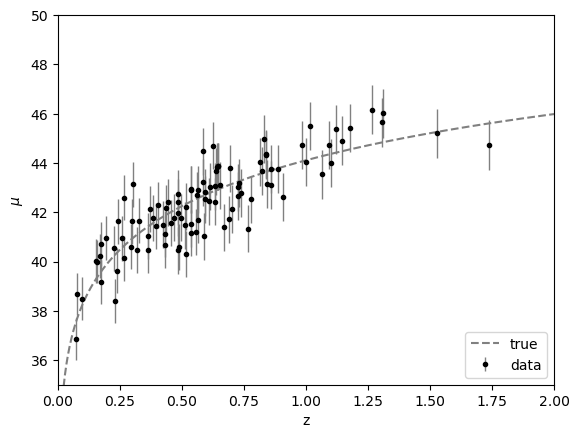

In [52]:
import numpy as np
import matplotlib.pyplot as plt

from astroML.datasets import generate_mu_z

z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')

# WE already know the solution...

from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=71, Om0=0.27, Ode0=1-0.27)
z = np.linspace(0.01, 2, 1000)
mu_true = cosmo.distmod(z)
plt.plot(z, mu_true, '--', c='gray',label='true')


plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

plt.show()

####  Tasks

- First, explore fitting this data with the tecniques we have seen.
- Start from linear regression and polynomial regression
- For the case of  polynomial regression, just fit many of them for now.
- Let's bet based on intuition! Which fit is the best?
- In what cases are you underfitting the data?
- In what cases are you overfitting the data?
- Now split the data into training and validation sets
- Implement a cross-validation procedure
- Pick the best!
- Does it agree with our bets?

#### If you have time (or later at home...)

- Repeat with Basis Function Regression and Kernel Regression
- Explore what happens when you change the number of datapoints and plot the resulting learning curves.

In [53]:
# sklearn format

X = z_sample[:,np.newaxis]
print(X.shape)

y = mu_sample 
print(y.shape)

dy = dmu 
print(dy.shape)

(100, 1)
(100,)
(100,)


39.60456481105869 [4.5911933]


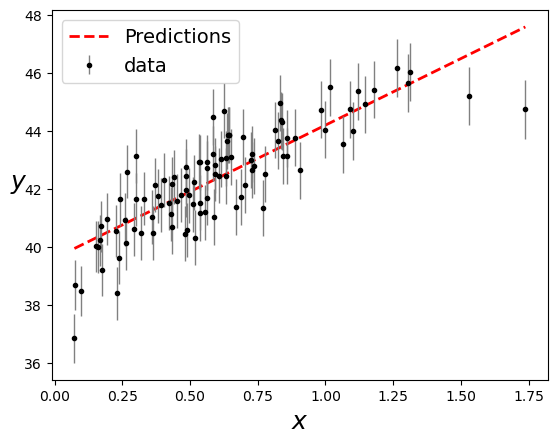

In [54]:
# Linear Regression

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y, err)

theta0 = lin_reg.intercept_
theta1 = lin_reg.coef_

print(theta0, theta1)

X_new = np.linspace(min(z_sample),max(z_sample))
X_new = X_new[:,np.newaxis]

y_pred = lin_reg.predict(X_new)

plt.plot(X_new, y_pred, "r--", linewidth=2, label="Predictions")
plt.errorbar(X, y, err,  fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("$x$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.show()


(35.0, 50.0)

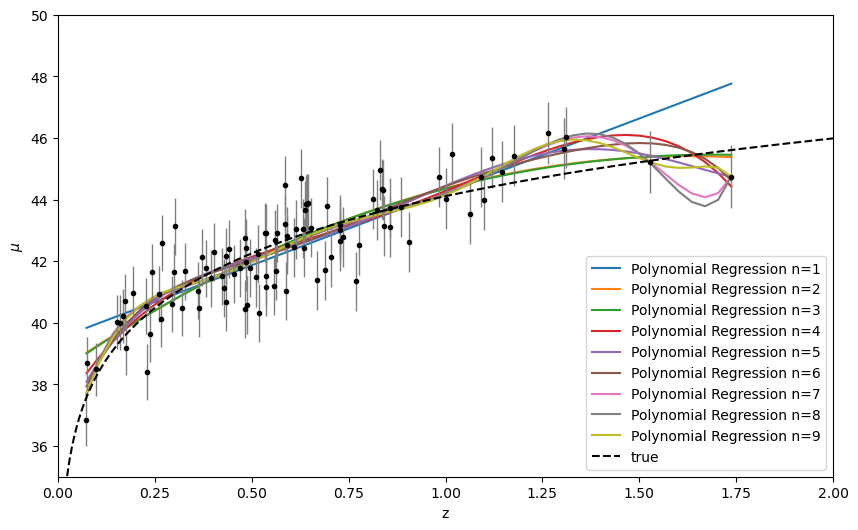

In [223]:
# Polynomial Regression
fig,_=plt.subplots(figsize=(10,6))

from astroML.linear_model import PolynomialRegression

z = np.linspace(min(z_sample),max(z_sample))

for n in range(1,10):

    regressor = PolynomialRegression(n)
    regressor.fit(X, y, err)
    mu_fit = regressor.predict(z[:,np.newaxis])
    plt.plot(z, mu_fit,label='Polynomial Regression n='+str(n))

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)

z = np.linspace(0.01, 2, 1000)
mu_true = cosmo.distmod(z)
plt.plot(z, mu_true, '--', c='black',label='true')

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)



# Cross Validation with simple Train-Test split

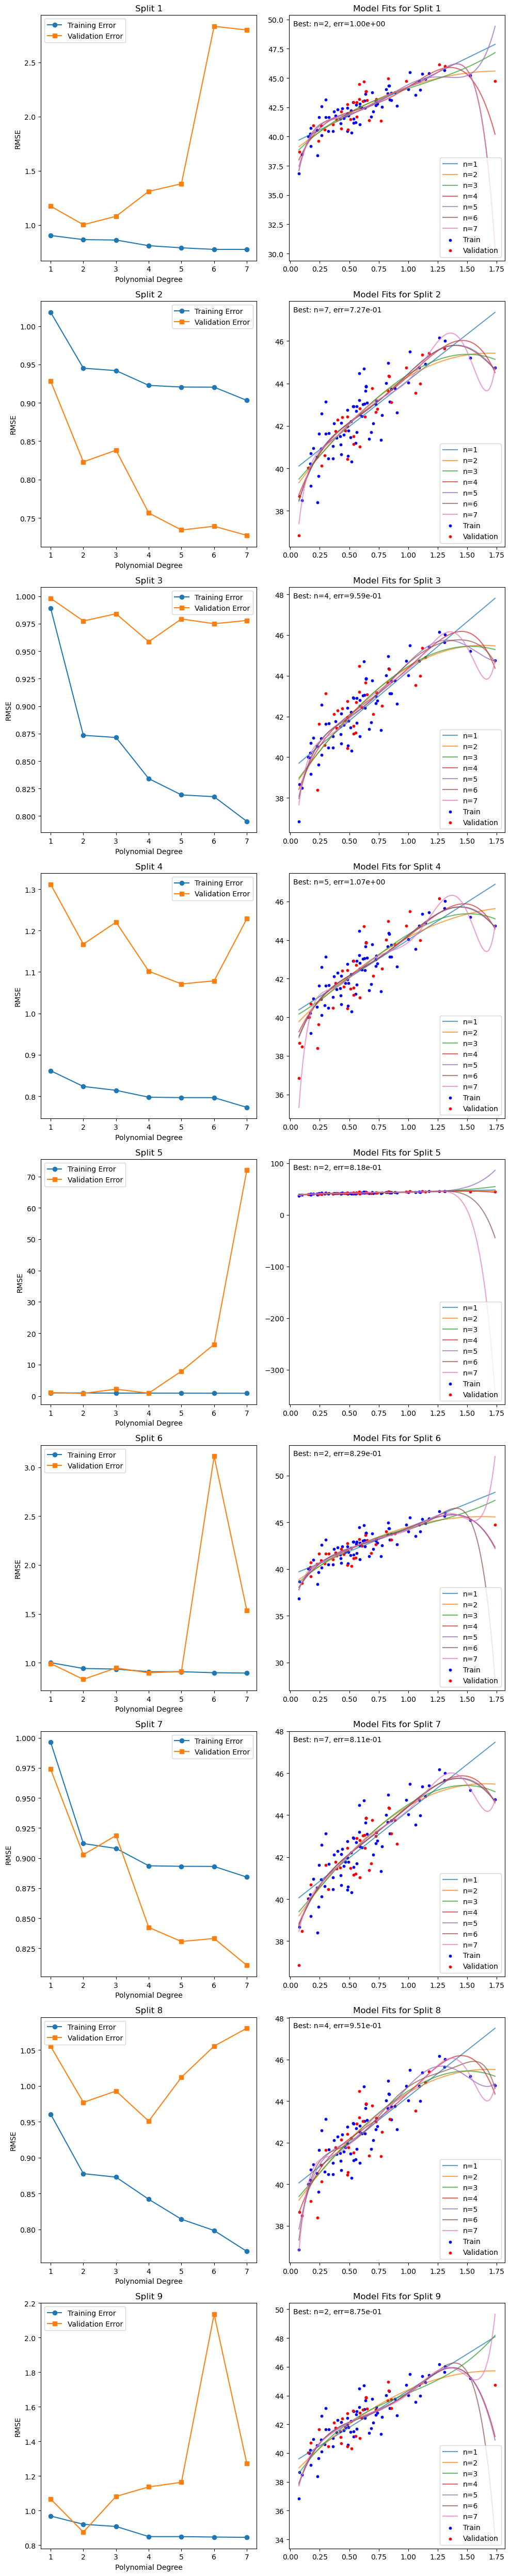

In [197]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from astroML.linear_model import PolynomialRegression

# Define RMSE loss function
def loss_function(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

# Settings
n_splits = 9
nrange = range(1, 8)
z = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)

fig, ax = plt.subplots(n_splits, 2, figsize=(10, 50))

for i in range(n_splits):
    # Random split
    X_train, X_val, ydy_train, ydy_val = train_test_split(
        X, np.column_stack([y, dy]),
        test_size=0.3,
        shuffle=True,
        random_state=None
    )
    y_train, dy_train = ydy_train.T
    y_val, dy_val = ydy_val.T

    etrain, evalidation = [], []

    for n in nrange:
        model = PolynomialRegression(n)
        model.fit(X_train, y_train, dy_train)

        # Predict and compute errors
        y_pred_train = model.predict(X_train)
        y_pred_val = model.predict(X_val)
        etrain.append(loss_function(y_train, y_pred_train))
        evalidation.append(loss_function(y_val, y_pred_val))

        # Plot model curve
        y_model = model.predict(z)
        ax[i, 1].plot(z, y_model, label=f"n={n}", alpha=0.7)

    # Plot error vs. degree
    ax[i, 0].plot(nrange, etrain, label='Training Error', marker='o')
    ax[i, 0].plot(nrange, evalidation, label='Validation Error', marker='s')
    ax[i, 0].set_xlabel('Polynomial Degree')
    ax[i, 0].set_ylabel('RMSE')
    ax[i, 0].legend()
    ax[i, 0].set_title(f"Split {i+1}")

    # Plot data points
    ax[i, 1].scatter(X_train, y_train, c='blue', label='Train', s=10)
    ax[i, 1].scatter(X_val, y_val, c='red', label='Validation', s=10)
    best_n = nrange[np.argmin(evalidation)]
    best_error = min(evalidation)

    # Annotate best model
    ax[i, 1].text(
        0.02, 0.98,
        f"Best: n={best_n}, err={best_error:.2e}",
        transform=ax[i, 1].transAxes,
        verticalalignment='top',
        horizontalalignment='left',
        fontsize=10
    )
    ax[i, 1].legend(loc='lower right')
    ax[i, 1].set_title(f"Model Fits for Split {i+1}")

plt.tight_layout()
plt.show()


# K-fold cross-validation

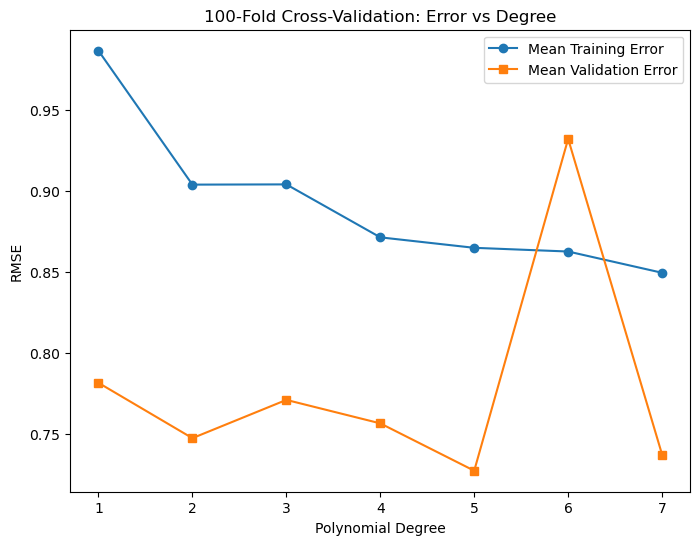

Best degree = 5, Validation RMSE = 0.7270


In [224]:
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
from astroML.linear_model import PolynomialRegression

# Loss function: Root Mean Squared Error
def loss_function(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

# Setup
nrange = range(1, 8)       # Polynomial degrees to test
K = 100                    # Number of folds
kf = KFold(n_splits=K, shuffle=True, random_state=42)

mean_train_errors = []
mean_val_errors = []

# Loop over degrees
for n in nrange:
    train_errors = []
    val_errors = []

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        dy_train, dy_val = dy[train_idx], dy[val_idx]

        model = PolynomialRegression(n)
        model.fit(X_train, y_train, dy_train)

        y_pred_train = model.predict(X_train)
        y_pred_val = model.predict(X_val)

        train_errors.append(loss_function(y_train, y_pred_train))
        val_errors.append(loss_function(y_val, y_pred_val))

    mean_train_errors.append(np.mean(train_errors))
    mean_val_errors.append(np.mean(val_errors))

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(nrange, mean_train_errors, 'o-', label='Mean Training Error')
plt.plot(nrange, mean_val_errors, 's-', label='Mean Validation Error')
plt.xlabel('Polynomial Degree')
plt.ylabel('RMSE')
plt.title(f"{K}-Fold Cross-Validation: Error vs Degree")
plt.legend()
plt.show()

# Best model selection
best_n = nrange[np.argmin(mean_val_errors)]
print(f"Best degree = {best_n}, Validation RMSE = {min(mean_val_errors):.4f}")